In [1]:
# start time - 1609492611000, 1641028611000, 1672564611000 (2021, 2022, 2023)
# start_time = 1635743450000 2021/11
# end_time = 1654060250000 2022/6 BEAR

In [2]:
# ! conda install -c conda-forge ta --yes

In [3]:
import requests
import pandas as pd
import ta
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import time
import os

In [4]:
from binance.client import Client
from dotenv import load_dotenv

# Get the path to the current directory
current_directory = os.getcwd()

# Specify the path to the .env file relative to the current directory
dotenv_path = os.path.join(current_directory, '.env')

# Load the environment variables from the .env file
load_dotenv(dotenv_path)

api_key = os.getenv('API_KEY')
api_secret = os.getenv('SECRET_KEY')

client = Client(api_key, api_secret, testnet = False)

In [5]:
timezone = 8
symbol = 'apeusdt'
interval = '15m'

# start epoch till now
start_time = 1635743450000
end_time = round(time.time() * 1000)
# end_time = 1654060250000

# step between timestamps in milliseconds
step = 10000

In [6]:
sl_atr = 4
tp_atr = 3
kd_dir = 'Up'

In [7]:
def get_historical(symbol, interval, start_time, end_time, step):
        
#     url = "https://api.binance.com/api/v3/klines"

    # Fetch the data using batch requests
    data = []    
    while start_time < end_time:
        limit = min(step, end_time - start_time + 1)  # Adjust the limit for the last batch
        response = client.get_klines(symbol=symbol.upper(), interval=interval, limit=limit, startTime=start_time)

        if len(response) == 0:
            break  # No more data available, exit the loop
        data.extend(response)
        start_time = response[-1][0] + 1
    
    # Convert the data to a DataFrame
    columns = [
        "Open_Time", "Open", "High", "Low", "Close", "Volume", "Close_Time",
        "Quote asset volume", "Number of trades", "Taker buy base asset volume",
        "Taker buy quote asset volume", "Ignore"
    ]
    raw_df = pd.DataFrame(data, columns=columns)   
    
    raw_df = raw_df[['Open_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Open_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    raw_df = raw_df.astype(convert_dict)
    
    raw_df['Open_Time'] = pd.to_datetime(raw_df['Open_Time'], unit = 'ms')
    raw_df['Open_Time'] = raw_df['Open_Time'] + pd.Timedelta(hours=timezone)
    raw_df['Open_Time'] = raw_df['Open_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    raw_df = raw_df.reset_index(drop=True)
    
    return raw_df

In [8]:
loop_start_time = time.time()
raw_df = get_historical(symbol, interval, start_time, end_time, step)
loop_end_time = time.time()
print("Time taken to execute for loop:", loop_end_time - loop_start_time, "seconds")
print(raw_df)

Time taken to execute for loop: 28.178521871566772 seconds
                 Open_Time    Open   Close     High     Low       Volume
0      2022-03-17 22:30:00  1.0000  9.1100  28.0000  1.0000  11595637.27
1      2022-03-17 22:45:00  9.1125  8.9091   9.5173  8.6001   4139045.83
2      2022-03-17 23:00:00  8.8895  8.8071   9.2990  8.7400   2597477.42
3      2022-03-17 23:15:00  8.8089  8.6489   9.0000  8.3581   1702596.78
4      2022-03-17 23:30:00  8.6489  7.9040   8.7975  7.7620   2442641.36
...                    ...     ...     ...      ...     ...          ...
44558  2023-06-25 03:15:00  2.1990  2.2010   2.2050  2.1950     65971.54
44559  2023-06-25 03:30:00  2.2010  2.2020   2.2040  2.1980     17242.77
44560  2023-06-25 03:45:00  2.2000  2.1970   2.2080  2.1960     78507.40
44561  2023-06-25 04:00:00  2.1970  2.1910   2.1980  2.1880     59707.49
44562  2023-06-25 04:15:00  2.1910  2.1900   2.1910  2.1880       672.64

[44563 rows x 6 columns]


In [9]:
df = raw_df.copy()

In [10]:
def check_cross(df, kd_dir):
    up = df['slow_k'] > df['slow_d']
    down = df['slow_k'] < df['slow_d']
    if kd_dir == 'Up':
        return up.diff() & up
    if kd_dir == 'Any':
        return up.diff()
    if kd_dir == 'Down':
        return down.diff() & down


def indicators(df, kd_dir):

# ema
    for i in (200, 500, 1000):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()        
        
# atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    kd_int = 17
    d_int = 5
   
    kd_df = pd.DataFrame()
    kd_df[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kd_df[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slow_k'] = (df['Close'] - kd_df[str(kd_int) + '-Low'])*100/(kd_df[str(kd_int) + '-High'] - kd_df[str(kd_int) + '-Low'])
    df['slow_d'] = df['slow_k'].rolling(d_int).mean()
    
# kd cross
    df['kd_cross'] = check_cross(df, kd_dir)

In [11]:
indicators(df, kd_dir)
print(df)

                 Open_Time    Open   Close     High     Low       Volume  \
0      2022-03-17 22:30:00  1.0000  9.1100  28.0000  1.0000  11595637.27   
1      2022-03-17 22:45:00  9.1125  8.9091   9.5173  8.6001   4139045.83   
2      2022-03-17 23:00:00  8.8895  8.8071   9.2990  8.7400   2597477.42   
3      2022-03-17 23:15:00  8.8089  8.6489   9.0000  8.3581   1702596.78   
4      2022-03-17 23:30:00  8.6489  7.9040   8.7975  7.7620   2442641.36   
...                    ...     ...     ...      ...     ...          ...   
44558  2023-06-25 03:15:00  2.1990  2.2010   2.2050  2.1950     65971.54   
44559  2023-06-25 03:30:00  2.2010  2.2020   2.2040  2.1980     17242.77   
44560  2023-06-25 03:45:00  2.2000  2.1970   2.2080  2.1960     78507.40   
44561  2023-06-25 04:00:00  2.1970  2.1910   2.1980  2.1880     59707.49   
44562  2023-06-25 04:15:00  2.1910  2.1900   2.1910  2.1880       672.64   

        ema_200   ema_500  ema_1000      bb_u      bb_m      bb_l       atr  \
0       

In [12]:
def conditions(df):
    # c1
    df['c1'] = df['Low'] <= df['bb_l']
    df['c2'] = df['Low'] <= df['ema_500']
    
    # c2, c3, c4
    df['c3'] = df['ema_200'] >= df['ema_500']
    df['c4'] = df['ema_500'] >= df['ema_1000']
    
    # c5, c6, c7
    df['c5'] = df['Volume'] >= df['Volume'].shift(1)
    df['c6'] = df['Close'] >= df['Open']
    df['c7'] = df['Close'].shift(1) <= df['Open'].shift(1)
    
    # signal
    df['signal'] = df['c1'] & df['c2'] & df['c3'] & df['c4'] & df['c5'] & df['c6'] & df['c7']
    
    # open_entry
    df['open_entry'] = df['signal'].shift()
    
    return df

In [13]:
loop_start_time = time.time()
entry_df = conditions(df).copy()
loop_end_time = time.time()
print("Time taken to execute for loop:", loop_end_time - loop_start_time, "seconds")

Time taken to execute for loop: 0.01499795913696289 seconds


In [14]:
in_position = False
stop_loss = np.nan
take_profit = np.nan
close_val = entry_df['Close']
atr_val = entry_df['atr']

entry_df['position'] = ''  # Create an empty column for position

for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif row['open_entry']:
        entry_df.at[index, 'entry_p'] = close_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = close_val.shift(1).at[index] - sl_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'take_profit'] = close_val.shift(1).at[index] + tp_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
        take_profit = entry_df.at[index, 'take_profit']

    elif in_position and row['Close'] <= stop_loss:
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan

    elif in_position and row['High'] >= take_profit:
        entry_df.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan
        
entry_df.to_csv('entry_df.csv')

raw_entry_df = entry_df.copy()

entry_df = entry_df[(entry_df['open_entry']) | (entry_df['position'] != '')]
print(entry_df)

                 Open_Time     Open    Close     High      Low      Volume  \
1185   2022-03-30 06:45:00  13.5535  13.6070  13.6650  13.5533   100555.74   
1213   2022-03-30 13:45:00  13.5048  14.1063  14.1309  13.4900  1297093.40   
1253   2022-03-30 23:45:00  13.8151  13.9598  13.9880  13.8127   217801.83   
1270   2022-03-31 04:00:00  13.8751  13.8200  13.9087  13.7815    94707.94   
1286   2022-03-31 08:00:00  14.2102  14.2787  14.3988  14.0645   478505.00   
...                    ...      ...      ...      ...      ...         ...   
41422  2023-05-23 11:15:00   3.4610   3.4830   3.4890   3.4610    53321.53   
41522  2023-05-24 12:15:00   3.4440   3.4460   3.4470   3.4420    12308.39   
41526  2023-05-24 13:15:00   3.4750   3.4810   3.4870   3.4740    28317.81   
41567  2023-05-24 23:30:00   3.3720   3.3720   3.3770   3.3680    23800.20   
41606  2023-05-25 09:15:00   3.3140   3.2710   3.3140   3.2530   123200.13   

         ema_200    ema_500   ema_1000       bb_u  ...    c4   

In [15]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Sell') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 100

col = ['Open_Time', 'Open', 'Close', 'High', 'Low', 'atr', 'position','entry_p', 'stop_loss', 'take_profit']
pos = pos_df[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Sell':
#             pos.at[index, 'exit_p'] = pos.at[index, 'Close']
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'take_profit']
                break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            pos.at[index, 'exit_p'] = pos.at[index, 'Open']
#             for i in range(index -1, -1, -1):
#                 if pos.at[i, 'position'] == 'Buy':
#                     pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
#                 break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee


# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算獲利/虧損次數
agg_amts = []

for i in range(len(pos) - 1, -1, -1):

    if pos.loc[i, 'position'] in ['Stop', 'Sell']:
        
        # look out for the + sign
        total_amt = pos.loc[i, 'amt'] + np.absolute(pos.loc[i, 'amt']) * fee
        
        # iterate backwards from the current row until reaching another 'Stop' or 'Sell'
        # watch out for the + in total_amt += trading_fee
        j = i - 1
        while j >= 0 and pos.loc[j, 'position'] not in ['Stop', 'Sell']:
            total_amt += pos.loc[j, 'amt']
            trading_fee = np.absolute(pos.loc[j, 'amt']) * fee
            total_amt += trading_fee
            j -= 1
        
        # add the aggregated amount to the list
        agg_amts.append(total_amt)

agg_amts.reverse()


# 計算進場最大部位，最大損益
consec_entry = 0
position_amt_sum = 0
max_consec_entry = 0
max_position = 0
max_profit = 0
max_loss = 0

for index, row in pos.iterrows():
    
    if row['position'] == 'Buy':
        
        consec_entry += 1
        position_amt_sum += row['amt']
        
    elif row['position'] in ['Sell', 'Stop']:
        
        if consec_entry > max_consec_entry:
            max_consec_entry = consec_entry
            max_position = position_amt_sum
            
        position_amt_sum += row['amt']
        
        if -position_amt_sum > max_profit:
            max_profit = -position_amt_sum
            
        if -position_amt_sum < max_loss:
            max_loss = -position_amt_sum
            
        consec_entry = 0
        position_amt_sum = 0
    
    else:
        pass

# 最大部位
profit_per = "{:.2f}%".format(ttl_profit / (max_position/leverage) * 100)


# 勝率
wins = 0
loses = 0

for trade in agg_amts:
    if trade < 0:
        wins += 1
    elif trade > 0:
        loses += 1

win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)
    
cumulative_values = []
cumulative_sum = 0

for value in agg_amts:
    cumulative_sum -= value
    cumulative_values.append(cumulative_sum)

max_drawdown = min(cumulative_values)

# 結果
result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Profit': [round(max_profit, 2)],
          'Max_Loss': [round(max_loss, 2)],
          'Max_Entry': [max_consec_entry],
          'Max_Position': [round(max_position, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate],
          'PF_Ratio': [round(ttl_profit/ttl_fee, 2)],
          'Max_Drawdown': [round(max_drawdown, 2)]}


result_df = pd.DataFrame(result)

print(result_df)
print()
print(pos)

pos.to_csv('pos.csv')


   Profit   Fee  Max_Profit  Max_Loss  Max_Entry  Max_Position Profit_%  \
0   710.7  44.0      190.27   -162.67          5       2240.08  317.27%   

  Win_Rate  PF_Ratio  Max_Drawdown  
0   83.33%     16.15         51.79  

               Open_Time     Open    Close     High      Low       atr  \
0    2022-03-30 06:45:00  13.5535  13.6070  13.6650  13.5533  0.172554   
1    2022-03-30 13:45:00  13.5048  14.1063  14.1309  13.4900  0.190927   
2    2022-03-30 23:45:00  13.8151  13.9598  13.9880  13.8127  0.186465   
3    2022-03-31 04:00:00  13.8751  13.8200  13.9087  13.7815  0.167961   
4    2022-03-31 08:00:00  14.2102  14.2787  14.3988  14.0645  0.168850   
..                   ...      ...      ...      ...      ...       ...   
108  2023-05-23 11:15:00   3.4610   3.4830   3.4890   3.4610  0.011478   
109  2023-05-24 12:15:00   3.4440   3.4460   3.4470   3.4420  0.013263   
110  2023-05-24 13:15:00   3.4750   3.4810   3.4870   3.4740  0.013163   
111  2023-05-24 23:30:00   3.3720 

In [16]:
plt_df = pos[['Open_Time', 'position', 'amt']]

cumulative_sum = 0
agg_amts = []
stop_date = None

for index, row in plt_df.iterrows():
    if row['position'] == 'Buy':
        cumulative_sum += row['amt']
    elif row['position'] == 'Stop' or row['position'] == 'Sell':
        cumulative_sum += row['amt']
        stop_date = row['Open_Time']
        agg_amts.append((stop_date, cumulative_sum))
        cumulative_sum = 0

        
# Convert the list of tuples into a new dataframe
agg_df = pd.DataFrame(agg_amts, columns=['date', 'cumulative_sum'])
agg_df['cumulative_sum'] = agg_df['cumulative_sum'].apply(lambda x: -x)

print(agg_df['cumulative_sum'].sum())
print(agg_df)

754.6995000000006
                   date  cumulative_sum
0   2022-03-30 13:45:00         53.1707
1   2022-03-31 08:00:00        108.6477
2   2022-04-01 23:15:00         72.4726
3   2022-04-16 23:00:00          4.6400
4   2022-04-17 06:00:00         33.8967
5   2022-04-23 00:15:00        141.8602
6   2022-04-30 10:00:00        190.2661
7   2022-05-02 19:00:00       -162.6700
8   2022-07-01 07:00:00         10.1911
9   2022-07-11 09:15:00        -50.2700
10  2022-08-03 11:45:00         55.3012
11  2022-08-08 13:45:00         11.1893
12  2022-08-09 12:45:00         14.0890
13  2022-09-15 13:45:00         22.0797
14  2022-09-19 08:45:00         16.9426
15  2022-09-26 00:30:00         13.3936
16  2022-10-28 22:15:00         41.1188
17  2022-10-31 15:45:00         17.6700
18  2022-11-07 15:30:00        -16.8000
19  2022-11-08 03:30:00         12.1055
20  2022-12-02 19:15:00         10.8378
21  2022-12-04 10:30:00          8.5567
22  2022-12-06 14:45:00         10.6670
23  2022-12-09 20:30:0

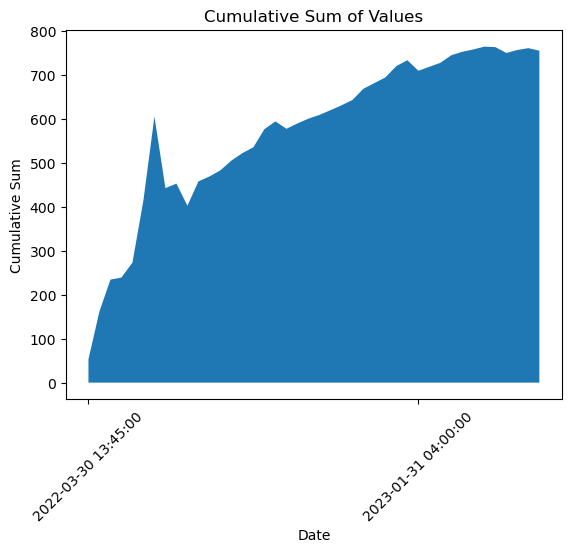

51.78875465000011


In [17]:
cumulative_values = []
cumulative_sum = 0
for value in agg_df['cumulative_sum']:
    cumulative_sum += value
    cumulative_values.append(cumulative_sum)

plt.fill_between(agg_df['date'], cumulative_values, 0)

plt.xlabel('Date')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Values')


n = 30  # Adjust the value of n as per your preference
plt.xticks(agg_df['date'][::n], rotation=45)
plt.show()

print(max_drawdown)
# print(cumulative_values)

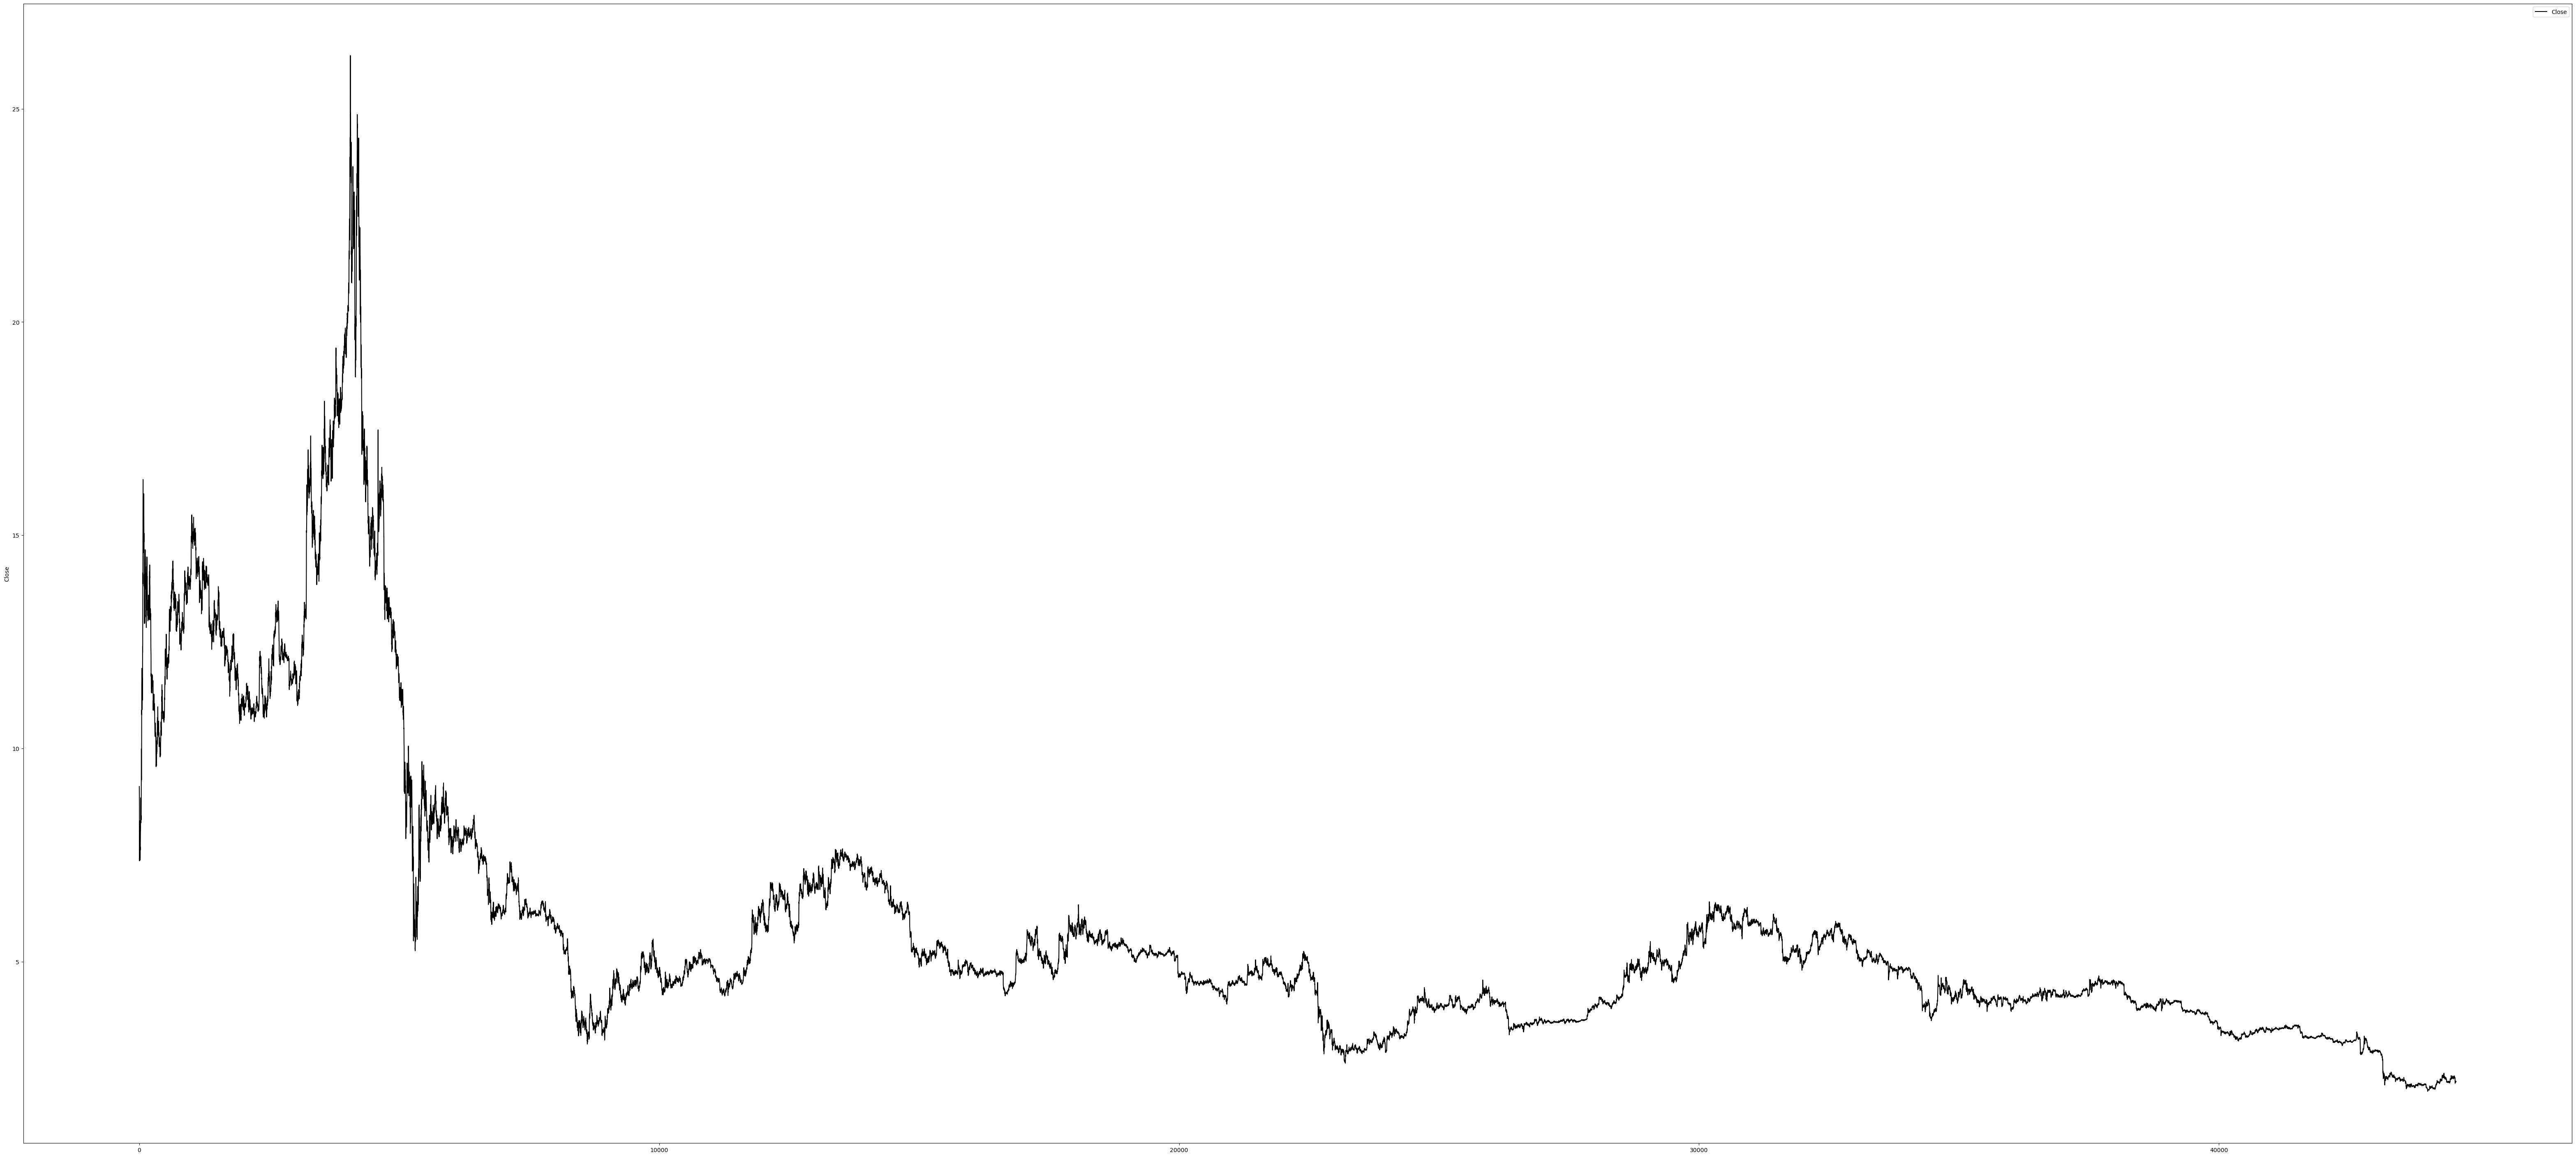

In [18]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')

i = 0
while i < len(plt_df):
    if pd.isna(plt_df.position[i]):
        i += 1
    elif plt_df.position[i] == 'Buy':
        j = i + 1
        while j < len(plt_df) and (pd.isna(plt_df.position[j]) or plt_df.position[j] == 'Buy'):
            j += 1
        if j < len(plt_df) and plt_df.position[j] == 'Sell':
            # Paint all previous 'Buy's green dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'go', label='_', markersize=20)
            i = j
        elif j < len(plt_df) and plt_df.position[j] == 'Stop':
            # Paint all previous 'Buy's red dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'ro', label='_', markersize=20)
            i = j + 1
        else:
            i = j
    else:
        i += 1

plt.legend()
plt.show()


# 之所以出現大量紅點，原因為：連續加倉會調整整個部位停利和停損，因此一些進倉部位會因為調高後的＂整個部位＂停損而出場，但該入場損益依舊為正
# 意思是該部位之停損已經高於許多前面部位之進場點位